## Frequent Pattern Mining in Spark
source: https://colab.research.google.com/drive/1Db3fj_3jlDXgdrFWH6fUe03QF6ZT5EL5?usp=sharing

### Setup

Let's set up Spark on your Colab environment.  Run the cell below!

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 22 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package libxtst6:amd64.
(Reading database ... 124935 files and directories currently installed.)
Preparing to unpack .../libxtst6_2%3a1.2.3-1build4_amd64.deb ...
Unpacking libxtst6:amd64 (2:1.2.3-1build4) ...
Selecting previously unselected package openjdk-8-jre-headless:amd64.
Preparing to unpack .../openjdk-8-jre-headless_8u442-b06~us1-0ubuntu1~22.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u442-b06~us1-0

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now we authenticate a Google Drive client to download the file we will be processing in our Spark job.

**Make sure to follow the interactive instructions.**

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
id='1dhi1F78ssqR8gE6U-AgB80ZW7V_9snX4'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('products.csv')

id='1KZBNEaIyMTcsRV817us6uLZgm-Mii8oU'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('order_products__train.csv')

If you executed the cells above, you should be able to see the dataset we will need for this Colab under the "Files" tab on the left panel.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

Let's initialize the Spark context.

In [6]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

### Your task

If you run successfully the setup stage, you are ready to work with the **3 Million Instacart Orders** dataset. In case you want to read more about it, check the [official Instacart blog post](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2) about it, a concise [schema description](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b) of the dataset, and the [download page](https://www.instacart.com/datasets/grocery-shopping-2017).

In this Colab, we will be working only with a small training dataset (~131K orders) to perform fast Frequent Pattern Mining with the FP-Growth algorithm.

In [7]:
products = spark.read.csv('products.csv', header=True, inferSchema=True)
orders = spark.read.csv('order_products__train.csv', header=True, inferSchema=True)

In [8]:
products.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- aisle_id: string (nullable = true)
 |-- department_id: string (nullable = true)



In [9]:
orders.printSchema()

root
 |-- order_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- add_to_cart_order: integer (nullable = true)
 |-- reordered: integer (nullable = true)



Use the Spark Dataframe API to join 'products' and 'orders', so that you will be able to see the product names in each transaction (and not only their ids).  Then, group by the orders by 'order_id' to obtain one row per basket (i.e., set of products purchased together by one customer).

In [12]:
# YOUR CODE HERE
# Add by Hui Lin in 02/25/2024

# Join two tables on 'product_id'
joined_df = products.join(orders, on='product_id', how='inner')

# Grouped by 'order_id' and collect the product names for each order
grouped_df = joined_df.groupBy('order_id').agg(collect_list('product_name').alias('pname_bskt'))

# take a look at the joined table
grouped_df.show()

+--------+--------------------+
|order_id|          pname_bskt|
+--------+--------------------+
|       1|[Bulgarian Yogurt...|
|      96|[Roasted Turkey, ...|
|     112|[Fresh Cauliflowe...|
|     218|[Natural Artisan ...|
|     456|[Chorizo Pork, Pe...|
|     473|[Organic Whole Mi...|
|     631|[Organic Strawber...|
|     762|[Organic Strawber...|
|     774|[Ice Cream Variet...|
|     844|[Green Beans, Org...|
|     904|[Cup Noodles Chic...|
|     988|[Natural Vanilla ...|
|    1032|[Clover Org Greek...|
|    1077|[Bag of Organic B...|
|    1119|[Boneless Skinles...|
|    1139|[Banana, Organic ...|
|    1143|[Natural Premium ...|
|    1145|[Banana, Original...|
|    1275|[Boneless Skinles...|
|    1280|[Lactose Free Hal...|
+--------+--------------------+
only showing top 20 rows



In this Colab we will explore [MLlib](https://spark.apache.org/mllib/), Apache Spark's scalable machine learning library. Specifically, you can use its implementation of the [FP-Growth](https://spark.apache.org/docs/latest/ml-frequent-pattern-mining.html#fp-growth) algorithm to perform efficiently Frequent Pattern Mining in Spark.
Use the Python example in the documentation, and train a model with

```minSupport=0.01``` and ```minConfidence=0.5```



In [17]:
# YOUR CODE HERE
# Try to use the FP-Growth model  add by Hui Lin 02/25/2025

from pyspark.ml.fpm import FPGrowth

# Prepare the data for FP - Growth : convert the
fp_data = grouped_df.select('pname_bskt').withColumnRenamed('pname_bskt', 'items')

# set up FP-Growth model using the assigned parameters
#fpGrowth = FPGrowth(itemsCol="items", minSupport=0.01, minConfidence=0.5)  # default parameters from references
fpGrowth = FPGrowth(itemsCol="items", minSupport=0.005, minConfidence=0.3)  # do some adjustment

# to train the model
model = fpGrowth.fit(fp_data)

# take a look what happen
print("Frequent Itemsets:")
model.freqItemsets.show()

print("Association Rules:")
model.associationRules.show()

# try to predict
print("Predictions:")
model.transform(fp_data).show()

Frequent Itemsets:
+--------------------+----+
|               items|freq|
+--------------------+----+
|[Total 0% Nonfat ...| 993|
|[Organic Large Gr...| 730|
|      [Green Onions]|1445|
|[Organic Tomato B...| 772|
|[Organic Egg Whites]| 834|
|[Flat Parsley, Bu...| 658|
|[Organic Baby Rai...| 914|
|     [Organic Basil]|1222|
|[Organic Large Br...|1137|
|    [Classic Hummus]| 694|
|[100% Raw Coconut...|1298|
|       [Green Beans]|1160|
|          [Lemonade]| 791|
|[Creamy Almond Bu...| 850|
|   [Red Raspberries]|1493|
|[Boneless Skinles...| 943|
|    [Organic Banana]|2332|
|  [Jalapeno Peppers]|1899|
|[Organic Large Ex...|2891|
|[Organic Large Ex...| 973|
+--------------------+----+
only showing top 20 rows

Association Rules:
+--------------------+--------------------+-------------------+------------------+--------------------+
|          antecedent|          consequent|         confidence|              lift|             support|
+--------------------+--------------------+-------------

Compute how many frequent itemsets and association rules were generated by running FP-growth.


In [18]:
# YOUR CODE HERE
# Add by Hui Lin in 02/25/2025

# Compute the number of frequent itemsets
num_frequent_itemsets = model.freqItemsets.count()

# Compute the number of association rules
num_association_rules = model.associationRules.count()

# Print the results
print(f"Number of frequent itemsets generated: {num_frequent_itemsets}")
print(f"Number of association rules generated: {num_association_rules}")

Number of frequent itemsets generated: 364
Number of association rules generated: 13


Now, retrain the FP-Growth model, try different values for its parameters (e.g., minsupport, etc.), and compare the results. Analyze the outcomes and justify the optimal parameter values for the model.


In [21]:
# YOUR CODE HERE
# set a loop for finding the perfect parameters of  FP-Growth model Add by Hui Lin in 02/25/2025

import matplotlib.pyplot as plt


# set the scale of support and confidence treshstone
min_support_values = [0.001, 0.005, 0.01, 0.02]
min_confidence_values = [0.2, 0.3, 0.4, 0.5]

# save in results
results = []

# loop for different composed parameters
for min_support in min_support_values:
    for min_confidence in min_confidence_values:
        fpGrowth = FPGrowth(itemsCol="items", minSupport=min_support, minConfidence=min_confidence)
        model = fpGrowth.fit(fp_data)

        # Compute the number of frequent itemsets
        num_frequent_itemsets = model.freqItemsets.count()
        # Compute the number of association rules
        num_association_rules = model.associationRules.count()

        # save this loop's result
        result = {
            'min_support': min_support,
            'min_confidence': min_confidence,
            'num_frequent_itemsets': num_frequent_itemsets,
            'num_association_rules': num_association_rules
        }
        results.append(result)



    min_support  min_confidence  num_frequent_itemsets  num_association_rules
0         0.001             0.2                   4444                   1172
1         0.001             0.3                   4444                    347
2         0.001             0.4                   4444                     89
3         0.001             0.5                   4444                     11
4         0.005             0.2                    364                     55
5         0.005             0.3                    364                     13
6         0.005             0.4                    364                      1
7         0.005             0.5                    364                      0
8         0.010             0.2                    120                     12
9         0.010             0.3                    120                      3
10        0.010             0.4                    120                      0
11        0.010             0.5                    120          

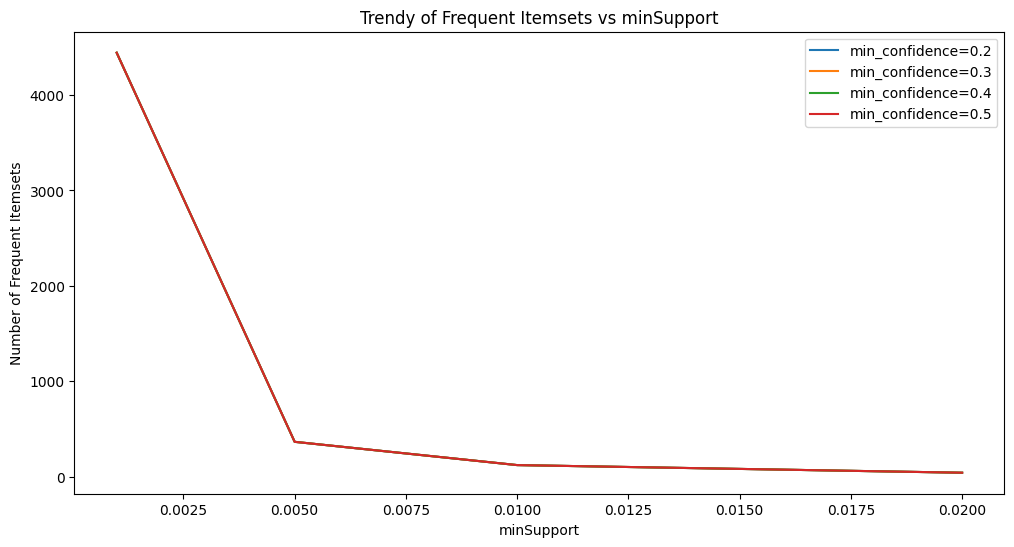

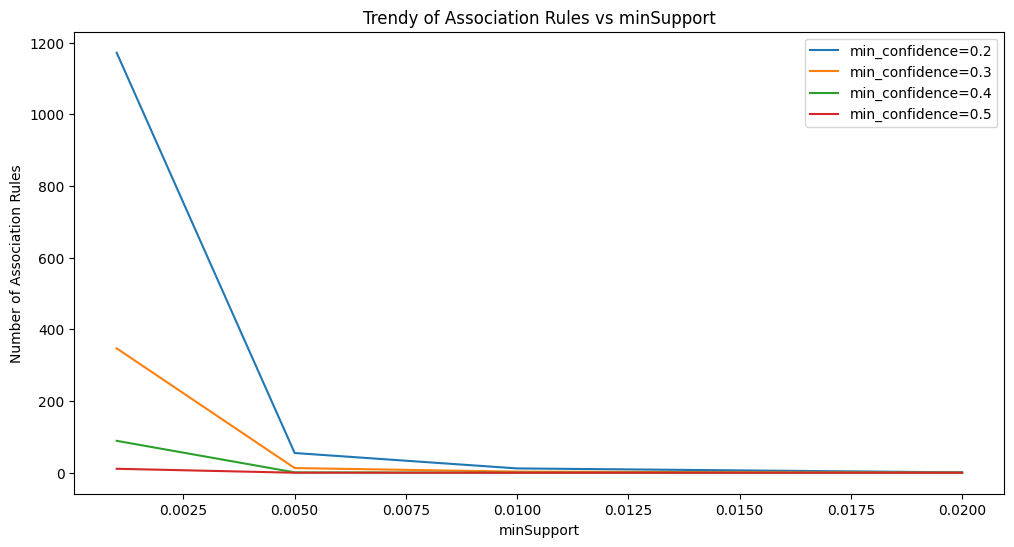

Optimal parameters:
   min_support  min_confidence  num_frequent_itemsets  num_association_rules
0        0.001             0.2                   4444                   1172


In [20]:
# show results in  DataFrame form
results_df = pd.DataFrame(results)
print(results_df)

# draw the trendy of  Frequent Itemsets
plt.figure(figsize=(12, 6))
for min_confidence in min_confidence_values:
    subset = results_df[results_df['min_confidence'] == min_confidence]
    plt.plot(subset['min_support'], subset['num_frequent_itemsets'], label=f'min_confidence={min_confidence}')
plt.xlabel('minSupport')
plt.ylabel('Number of Frequent Itemsets')
plt.title('Trendy of Frequent Itemsets vs minSupport')
plt.legend()
plt.show()

# draw the trendy of Association Rules
plt.figure(figsize=(12, 6))
for min_confidence in min_confidence_values:
    subset = results_df[results_df['min_confidence'] == min_confidence]
    plt.plot(subset['min_support'], subset['num_association_rules'], label=f'min_confidence={min_confidence}')
plt.xlabel('minSupport')
plt.ylabel('Number of Association Rules')
plt.title('Trendy of Association Rules vs minSupport')
plt.legend()
plt.show()

# Now we got the champion
optimal_result = results_df[results_df['num_association_rules'] == results_df['num_association_rules'].max()]
print("Optimal parameters:")
print(optimal_result)
